На Kaggle мне удалось найти датасет, содержащий комментарии, размеченные на токсичные и обычные (1 и 0). 
Воспользуемся им для обучения модели для будущего бота.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('labeled.csv')

data.tail()

,comment,toxic
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0
14411,До сих пор пересматриваю его видео. Орамбо кст...,0.0


In [2]:
data.shape

(14412, 2)

Проверим наличие пропусков в данных:

In [3]:
data.isnull().any().any()

False

Приведем целевую переменную к целому типу:

In [4]:
data['toxic'] = data['toxic'].astype('int32')
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


Посмотрим на распределение наших данных по классам (токсичные нетоксичные комментарии).

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

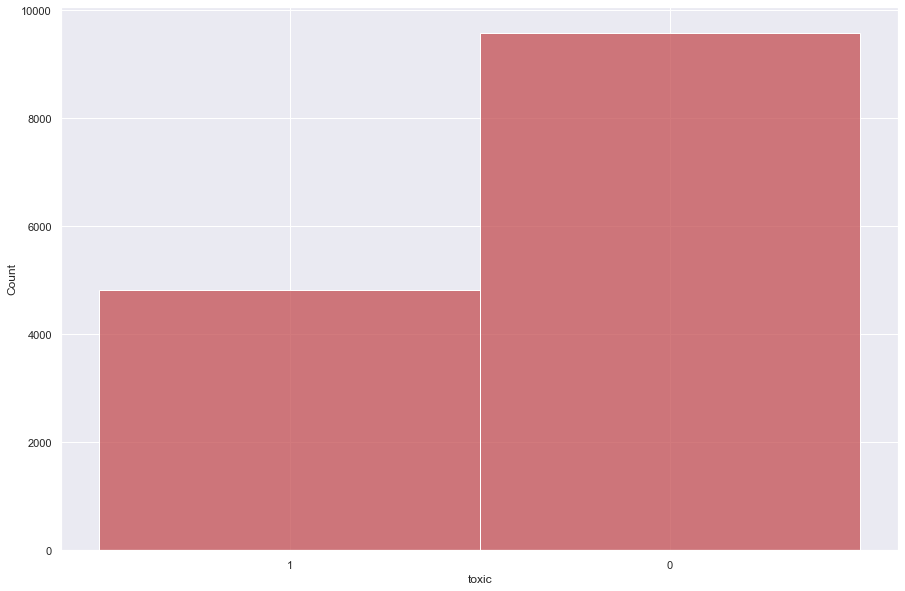

In [6]:
fig = plt.figure(figsize=(15, 10))
sns.histplot(data['toxic'].astype('str'), color='r')
plt.xticks()
plt.show()

Можем видеть, что классы распределены неравномерно -- число токсичных комментариев примерно в 2 раза меньше, чем обычных. А если быть точнее:

In [7]:
data['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

Проверим качество разметки, выведя несколько токсичных и нетоксичных комментариев.

In [8]:
[print(text) for text in data[data['toxic'] == 0]['comment'][15:17]]

Не понимаю как так получается. 15-20 лет назад хватало времени прослушать все перечисленные группы и не по одному альбому. Это только метал. Ещё хватало времени на панк и хардкор. При этом помимо работы был ещё институт в то время. Сейчас же совсем времени нет на музыку. Куда девается свободное время?

Мне Вас очень жаль, если для Вас оскорбления - норма.



[None, None]

In [9]:
[print(text) for text in data[data['toxic'] == 1]['comment'][15:17]]

Я вообще мимо шёл. Вот сейчас поплачу над твоей головушкой, подзалупная истеричка, и дальше пойду. Ты такой же тупой и обманутый ванька как и те воеваки. То что вы глупые, невоспитанные, бедные, без прошлого и будущего и вас наебали на этот ресентимент ушлые чекисты и такие жирные приживалы как Гейгорка и Гоблач - всё это не снимает личной ответственности за свою жизнь и поступки. Очень вас жаль, но руки тебе не подам, отгрызёшь.

Мэдисон Тоже такой же стример Это такой троллинг или тебя мать в детстве роняла? Тебе нравится прикидываться тупым или ты просто тупой?



[None, None]

Больше смотреть не на что, так что разделим данные на `train` и `test` и займемся обработкой.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = data['comment']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from string import punctuation, digits, ascii_lowercase

За стоп-символы будем считать знаки пунктуации, числа и английский алфавит (так как слова на английском практически не встречаются, и с их отсутствием смысл не меняется. При этом, немало сэмплов, где имеются ссылки и пр., но из-за пробелов их не так легко удалить регулярками). Также удалим слова, которые в русском языке используются очень часто при помощи `stopwords.words('russian')`

Напишем свой кастомный tokenizer, который будет:
1. Приводить текст к нижнему регистру
2. Разбивать текст на токены
3. Удалять токены, содержащие стоп-символы или являющиеся стоп-словами
4. Проводить стемминг при помощи SnowballStemmer

In [13]:
stop_symb = punctuation + digits + ascii_lowercase
stemmer = SnowballStemmer("russian")
sw = stopwords.words('russian')

In [14]:
def custom_tokenizer(s):
    s = [stemmer.stem(word) for word in word_tokenize(s.lower()) if word not in sw and word.translate(str.maketrans('', '', stop_symb)) == word]
    return s

Посмотрим на примере, что делает `custom_tokenizer`:

In [16]:
num_sample = 7
print(f"Исходный сэмпл: {X_train.iloc[num_sample]}\nРезультат: {custom_tokenizer(X_train.iloc[num_sample])}")

Исходный сэмпл: Согласен, но частично. Сейчас воруют в основном потому что почему бы и нет, а не от безысходности.

Результат: ['соглас', 'частичн', 'вор', 'основн', 'поч', 'безысходн']


Теперь токенизируем наши данные, используя `TfidfVectorizer` и наш катосмный токенайзер.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
%%time
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train = vectorizer.fit_transform(X_train)
X_train.shape

Wall time: 37.3 s


(11529, 26690)

Взглянем на топ слов в словаре:

In [19]:
import itertools

dict(itertools.islice(vectorizer.vocabulary_.items(), 10))

{'последн': 17087,
 'сер': 20825,
 'специальн': 21938,
 'смотр': 21423,
 'сериа': 20860,
 'законч': 6502,
 'эт': 26498,
 'тяжел': 23694,
 'работ': 18966,
 'долж': 5354}

In [20]:
%%time
X_test = vectorizer.transform(X_test)
X_test.shape

Wall time: 9.08 s


(2883, 26690)

Настало время обучить модель. Для начала я выбрал логистическую регрессию, так как она неплохо справляется с классификацией и легко обучается.

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
clf_lr = LogisticRegression(C=1.2)
clf_lr.fit(X_train, y_train)
y_predicted = clf_lr.predict(X_test)

Проверим работоспособность на отдельных примерах:

In [23]:
def is_toxic(comment, clf=clf_lr, vectorizer=vectorizer):
    print("Нетоксичный") if clf.predict(vectorizer.transform([comment]))[0] == 0 else print("Токсичный")

In [24]:
is_toxic('Как дела?')

Нетоксичный


In [25]:
is_toxic('Ты дурак')

Токсичный


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Посмотрим на метрики:

In [27]:
def make_metrics(y_test, y_predicted):
    print(f"Метрики:\nAccuracy: {accuracy_score(y_test, y_predicted)}\nPrecision: {precision_score(y_test, y_predicted)}")
    print(f"Recall: {recall_score(y_test, y_predicted)}\nF1: {f1_score(y_test, y_predicted)}")

In [28]:
make_metrics(y_test, y_predicted)

Метрики:
Accuracy: 0.858480749219563
Precision: 0.8864628820960698
Recall: 0.6485623003194888
F1: 0.7490774907749077


Как можно видеть, `recall` слишком низкий, в нашей задаче, пусть неточно, но лучше удалять больше комментариев, чем с большей точностью, но пропускать токсичные. Попробуем выбрать порог, где `precision` будет пониже, но еще вполне допустимый -- например, `0.8`:

In [30]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

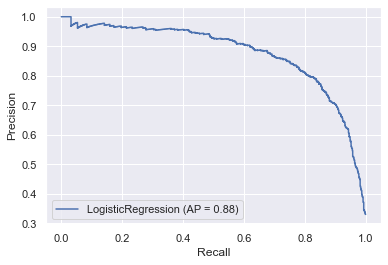

In [31]:
plot_precision_recall_curve(estimator=clf_lr, X=X_test, y=y_test)

In [32]:
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=clf_lr.predict_proba(X_test)[:, 1])

In [33]:
probas_pred = clf_lr.predict_proba(X_test)[:, 1] > thresholds[np.where(precision >= 0.8)[0][0]]

Посмотрим снова на метрики:

In [34]:
make_metrics(y_test, probas_pred)

Метрики:
Accuracy: 0.8733957682969129
Precision: 0.8002092050209205
Recall: 0.8146964856230032
F1: 0.8073878627968338


Видим, что `recall` заметно возрос (0.6485$ \rightarrow$ 0.8146), при это также выросли `accuracy` и `f1`.

Построим также матрицу ошибок:

In [35]:
from sklearn.metrics import plot_confusion_matrix

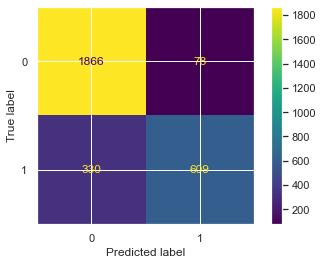

In [36]:
plot_confusion_matrix(clf_lr, X_test, y_test)

Видим, что у нас 330 **False Negative** значений, то есть тех комментариев, которые являются токсичными, но модель их определила, как обычные. Это, конечно, не самый лучший показатель.

Попробуем воспользоваться методом опорных векторов. Он обучается дольше, но справляться должен лучше.

In [37]:
from sklearn.svm import SVC

In [38]:
clf_svm = SVC()
clf_svm.fit(X_train, y_train)
y_predicted = clf_svm.predict(X_test)

In [39]:
make_metrics(y_test, y_predicted)

Метрики:
Accuracy: 0.8633368019424211
Precision: 0.8800557880055788
Recall: 0.6719914802981896
F1: 0.7620772946859903


**SVM** с дефолтными настройкми справился немного лучше, чем логистическая регрессия. Попробуем подобрать порог.

Обучим заново классификатор на SVM, но добавим параметр `probability=True` для подсчета вероятностей:

In [41]:
clf_svm = SVC(C=1.2, probability=True)
clf_svm.fit(X_train, y_train)
y_predicted = clf_svm.predict(X_test)

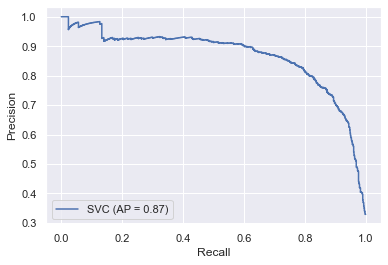

In [42]:
plot_precision_recall_curve(estimator=clf_svm, X=X_test, y=y_test)

In [43]:
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=clf_svm.predict_proba(X_test)[:, 1])

In [44]:
probas_pred = clf_svm.predict_proba(X_test)[:, 1] > thresholds[np.where(precision >= 0.8)[0][0]]

In [45]:
make_metrics(y_test, probas_pred)

Метрики:
Accuracy: 0.8737426292056886
Precision: 0.799791449426486
Recall: 0.8168264110756124
F1: 0.8082191780821919


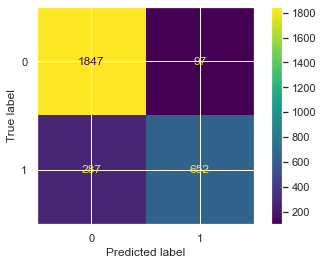

In [46]:
plot_confusion_matrix(clf_svm, X_test, y_test)

Метрики особо не изменились по сравнению с логистической регрессией, но зато **FN** значений стало меньше! Так же увеличилось число правильно распознанных токсичных комментариев.

Попробуем подобрать гиперпараметры получше для нашего классификатора.

Мне лень заново грид серч запускать, но там правда не очень (можно посмотреть предыдущие коммиты:))

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}

In [ ]:
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train,y_train)

In [ ]:
print(grid.best_estimator_)

In [ ]:
clf_svm = SVC(C=10, gamma=0.1, probability=True)
clf_svm.fit(X_train, y_train)
y_predicted = clf_svm.predict(X_test)

In [ ]:
plot_precision_recall_curve(estimator=clf_svm, X=X_test, y=y_test)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=clf_svm.predict_proba(X_test)[:, 1])
probas_pred = clf_svm.predict_proba(X_test)[:, 1] > thresholds[np.where(precision >= 0.8)[0][0]]

In [ ]:
make_metrics(y_test, probas_pred)

In [ ]:
plot_confusion_matrix(clf_svm, X_test, y_test)

До изменения порога модель и правда выдала более лучший результат, но с нужным нам значением `precision` остальные метрики заметно хуже, чем у классификатора до подбора гиперпараметров. Хотя стоит учесть, что число **FN** значений снова заметно уменьшилось и число правильно распознанных токсичных комментариев вновь увеличилось.

*Возможно, в силу небольшого размера датасета и неизвестного качества разметки добиться колоссального улучшения не получится, используя методы классического машинного обучения.*

**Но можно попробовать разбить длинные комментарии на два отдельных. При этом обоим частям будем присваивать метку исходного текста. А также будем надеяться, что это действительно так:) Ведь скорее всего в длинных комментариях окраска сохраняется на всем протяжении, а не в единственном предложении.**

Создадим маску для комментариев, содержащих как минимум 40 слов:

In [47]:
data_mask = data['comment'].apply(lambda x: len(x.split(' ')) >= 40)

In [48]:
long_data = data[data_mask]
long_data.shape

(2654, 2)

Оказывается, что такие комментарии составляют почти 20%!

In [49]:
ind_split = long_data['comment'].apply(lambda x: len(' '.join(x.split(' ')[:len(x.split(' ')) // 2])))
split_data = long_data.copy()
new_comm = []
for index, row in long_data.iterrows():
    split_data.at[index, 'comment'] = row['comment'][:ind_split[index]]
    new_comm.append(row['comment'])
new_data = pd.DataFrame({'comment': new_comm, 'toxic': split_data['toxic']})

In [50]:
data[data_mask] = split_data
data = pd.concat([data, new_data], ignore_index=True)

Посмотрим на новый размер датасета:

In [51]:
data.shape

(17066, 2)

Теперь повторим все для новых данных...

In [79]:
X = data['comment']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
%%time
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train = vectorizer.fit_transform(X_train)
X_train.shape

Wall time: 43.9 s


(13652, 27654)

In [81]:
%%time
X_test = vectorizer.transform(X_test)
X_test.shape

Wall time: 11.4 s


(3414, 27654)

In [82]:
clf_svm = SVC(C=1.2, probability=True)
clf_svm.fit(X_train, y_train)
y_predicted = clf_svm.predict(X_test)

In [87]:
make_metrics(y_test, y_predicted)

Метрики:
Accuracy: 0.8886936145284124
Precision: 0.9185779816513762
Recall: 0.7216216216216216
F1: 0.8082744702320888


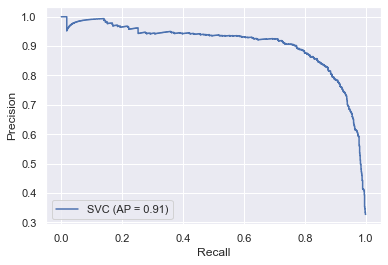

In [83]:
plot_precision_recall_curve(estimator=clf_svm, X=X_test, y=y_test)

Судя по PR-кривой, мы можем поднять порог до `precision`$=0.85$:

In [84]:
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=clf_svm.predict_proba(X_test)[:, 1])
probas_pred = clf_svm.predict_proba(X_test)[:, 1] > thresholds[np.where(precision >= 0.85)[0][0]]

In [85]:
make_metrics(y_test, probas_pred)

Метрики:
Accuracy: 0.9007029876977153
Precision: 0.8507734303912647
Recall: 0.8423423423423423
F1: 0.8465368945224082


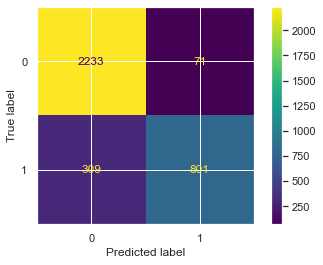

In [86]:
plot_confusion_matrix(clf_svm, X_test, y_test)

Результат налицо -- при повышенном `precision` мы получили  `recall`$=0.84$! Мы стали распознавать правильно гораздо больше токсичных комментариев (и нетоксичных тоже)!

*Возможно, стоит попробовать еще посплитить комментарии, так как в датасете все еще остались слишком длинные.*

Теперь проведем обучение на всем датасете, чтобы сохранить обученную модель и векторайзер уже для использования в боте!

In [61]:
%%time
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
X = vectorizer.fit_transform(X)
X.shape

Wall time: 59.2 s


(17066, 30209)

In [62]:
clf_svm = SVC(C=1.2, probability=True)
clf_svm.fit(X, y)

SVC(C=1.2, probability=True)

In [63]:
import pickle
pickle.dump(clf_svm, open('pretrained_clf', 'wb'))

In [64]:
pickle.dump(vectorizer, open('pretrained_vect', 'wb'))

Проверим, что сохраненная модель корректно работает:

In [65]:
loaded_model = pickle.load(open('pretrained_clf', 'rb'))
loaded_vect = pickle.load(open('pretrained_vect', 'rb'))

In [77]:
is_toxic('Что делаешь?', clf=loaded_model, vectorizer=loaded_vect)

Нетоксичный
